# スライスサンプリング

In [30]:
import matplotlib.pyplot as plt
import numpy as np

rng = np.random.default_rng()

## 目的分布

多峰性のある分布$p(z)$を考える. $p(z)$自体は計算不可能だが, $\tilde{p}(z) = Z_p p(z)$が計算可能.

$$
\tilde{p}(z) = 3 \mathcal{N}(z | -4, 1^2) + 2 \mathcal{N} (z | 3, 2^2)
$$

$\cdots Z_p$の値が簡単にわかるが, 問題の設定が面倒だったのです. 許してほしい.

In [31]:
def norm_pdf(z, mu, var):
    return np.exp(- ((z-mu) ** 2) / (2 * var)) / ((2 * np.pi * var) ** (1/2))

def tilde_p(z):
    return 3*norm_pdf(z, -4, 1) + 2*norm_pdf(z, 3, 4)

## スライスサンプリングの手順

1. $z$に初期値$z^{(0)}$を与える.
2. 各$\tau = 1, 2, \cdots, T$について, 以下のSTEP2~5を繰り返す
3. $u^{(\tau)} \sim \text{Uni}(0, \tilde{p}(z^{(\tau-1)}))$をサンプリング
4. 領域$Z^{(\tau)} = \{ z | \tilde{p}(z) > u^{(\tau)} \}$を計算
5. $z^{(\tau)} \sim \text{Uni}(z^{(\tau)})$をサンプリング, サンプルとして保存.

STEP4の計算は一般的に困難(非連続区間になる)なので, $Z^{(\tau)}$のうち$z=z^{(\tau-1)}$が含まれる連続区間を代わりに計算する.

### 連続区間の計算: stepping-out法

連続区間の計算すら解析解が得られないので, サンプリング区間を$z=z^{(\tau-1)}$を起点に左右へ広げていく手法を採用する. 具体的には,

1. $\lambda \sim \text{Uni}(0,1)$をサンプリングし, サンプリング区間の下限$L = z^{(\tau-1)}-\lambda w $, 上限$R = z^{(\tau-1)}+(1-\lambda) w$を初期化
2. 下限の拡張: $\tilde{p}(L) > u^{(\tau)}$を満たす限り$L \leftarrow L - w$を繰り返す
3. 上限の拡張: $\tilde{p}(R) > u^{(\tau)}$を満たす限り$R \leftarrow R + w$を繰り返す
4. 最終的な区間$(L, R)$をサンプリング区間とする

ただし, 区間$(L, R)$には$z < u^{(\tau)}$を満たす区間が含まれるので, サンプリングされた$z^{(\tau)} \sim \text{Uni}(z^{(\tau)})$は条件を満たさないかもしれない. その時はリサンプリングする.

In [32]:
def stepping_out(z, u, w=1.0):
    lambda_ = rng.uniform()
    left = z - lambda_*w
    right = z + (1 - lambda_)*w

    while tilde_p(left) > u: left -= w
    while tilde_p(right) > u: right += w

    return (left, right)

# burn-in process
z = 0.0
ITER = 1000 # iteration to burn-in
for _ in range(ITER):
    u = rng.uniform() * tilde_p(z)
    left, right = stepping_out(z, u)
    while True:
        z = rng.uniform() * (right - left) + left
        if (tilde_p(z) > u): break

size = 100000
sample = np.zeros(size)
for s in range(size):
    sample[s] = z
    u = rng.uniform() * tilde_p(z)
    left, right = stepping_out(z, u)
    while True:
        z = rng.uniform() * (right - left) + left
        if (tilde_p(z) > u): break

## 答え合わせ

見ればわかるが平均は

$$
\frac{3}{5} \times (-4) + \frac{2}{5} \times 3 = -1.2
$$

ぐらいである.

In [33]:
print(np.mean(sample))

-1.2373011148350974


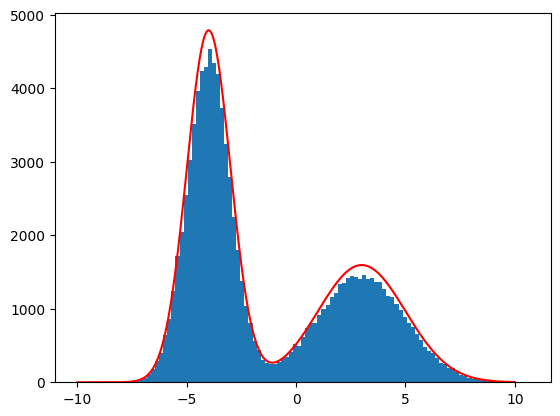

In [39]:
fig, ax = plt.subplots(1, 1)
z = np.linspace(-10, 10, 1000)
ax.plot(z, tilde_p(z) * 4000, "r-", label="tilde p")
ax.hist(sample, bins=100)
plt.show()

まあまあやね.